# Changing Eccentricity Sampling Simulations
This notebook is meant to create CDFs and calculate P-Values for multiple scaling factors for the Eccentricity Distribution. It creates a npy file that contains the CDF distribution as well as the p values for each population. The npy file is arranged as [[list of scaling factors used], [[population1], [population2]..., [population n]]]

In [39]:
#Variables to play with, eventually will be deprecated:
bin_number = 30

In [40]:
num_experiments = 100

In [41]:
#Import Statements & Define Constants
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import lognorm
from scipy.stats import ks_2samp
import math
import rebound
import random 
from random import choice
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
import itertools
from spock import FeatureClassifier
import spock
from decimal import Decimal
import pandas as pd
from tqdm import tqdm
from matplotlib.ticker import EngFormatter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
print(spock.__version__)

import dispersion as disp

%matplotlib inline

fmodel = FeatureClassifier()
earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass

0.1.0.dev299+gc0f9412


# Load NASA Exoplanet Archive data needed
Use archive to find planets that have compact inner period ratios

In [42]:
# load data of planets that have inner period ratio 1.1-1.5
df = pd.read_csv("compact_planet_data_2024.csv", index_col=0)
#massdf = pd.read_csv("Just_masses-Copy1.csv", index_col=0)
print(massdf)

       Planet Name   Host Name  Orbital Period Discovery Method  \
130       DMPP-1 b      DMPP-1       18.570000  Radial Velocity   
131       DMPP-1 c      DMPP-1        6.584000  Radial Velocity   
133       DMPP-1 e      DMPP-1        5.516000  Radial Velocity   
208       GJ 180 b      GJ 180       17.133000  Radial Velocity   
209       GJ 180 c      GJ 180       24.329000  Radial Velocity   
...            ...         ...             ...              ...   
5038    TOI-1246 c    TOI-1246        5.904137          Transit   
5039    TOI-1246 d    TOI-1246       18.654874          Transit   
5455  TRAPPIST-1 f  TRAPPIST-1        9.207540          Transit   
5456  TRAPPIST-1 g  TRAPPIST-1       12.352446          Transit   
5457  TRAPPIST-1 h  TRAPPIST-1       18.772866          Transit   

      Semi-Major Axis (AU)  Eccentricity  Radius (R_earth)  \
130                0.14620       0.08300             5.290   
131                0.07330       0.05700             3.060   
133      

# load from prelim .npy

In [43]:
pratios_observed = np.load('observed_periods_2024.npy')

In [44]:
observed_period_cdf = np.load('observed_period_cdf.npy')

In [45]:
kde_changing = np.load('kde_changing.npy')

In [46]:
kde_changing

array([0.5       , 0.57434918, 0.65975396, 0.75785828, 0.87055056,
       1.        , 1.14869835, 1.31950791, 1.51571657, 1.74110113,
       2.        ])

In [47]:
e_list = np.load('e_list.npy')
m_list_orig = np.load('m_list.npy')

0


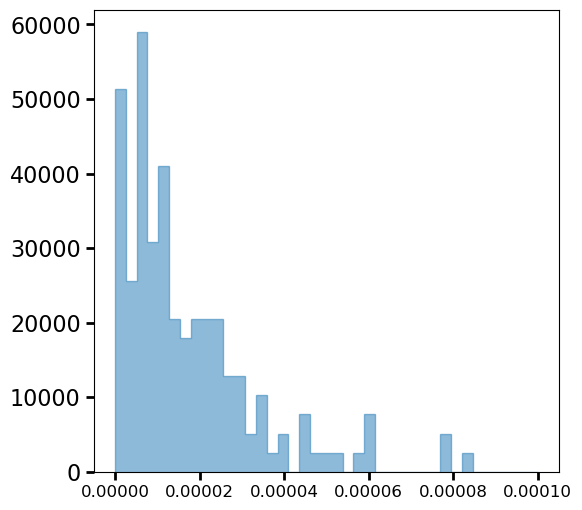

In [49]:
massdf["Star/Planet Ratio"] = (df['Stellar Mass (M_sun)'].to_numpy()/df["Mass or Mass * sin(i) (M_earth)"].to_numpy())**(-1)
plt.style.use('./paper.mplstyle')

#print(df["Mass or Mass * sin(i) (M_earth)"].values)
#print(df['Stellar Mass (M_sun)'].values)
#print(df["Star/Planet Ratio"].values)
ratios = massdf["Star/Planet Ratio"].to_numpy()
ratios = ratios[~np.isnan(ratios)]
ratios = ratios*(3*10**(-6))
ratios = ratios[ratios<0.0001]
#print([ratios,ratios.max()])
ratiogaussian = gaussian_kde(ratios) 
#print(type(ratiogaussian))
ratlist = ratiogaussian.resample(size=150000)[0]
ratlist = np.array([choice(ratios) for n in range(0,15000)])

ratlist = ratlist[ratlist > 0]
print(len(ratlist[ratlist<0]))
#plt.plot(np.linspace(0, 1.5, 40), kde(x_grid), label='Observed KDE')

n, bins_e, patches = plt.hist(ratios, bins=np.linspace(0, 0.0001, 40), histtype='step',fill=True, alpha=0.5, density=True, label = 'Observed')
#n1, bins1, patches1 = plt.hist(ratlist, bins=bins_e, histtype='step', fill=True, alpha=0.5, density=True, label = 'SPOCK');
#plt.title("Observed Planet-Star Mass Ratio Distribution")
plt.xticks(fontsize=12)

huh.savefig('ObsMassRat.pdf')

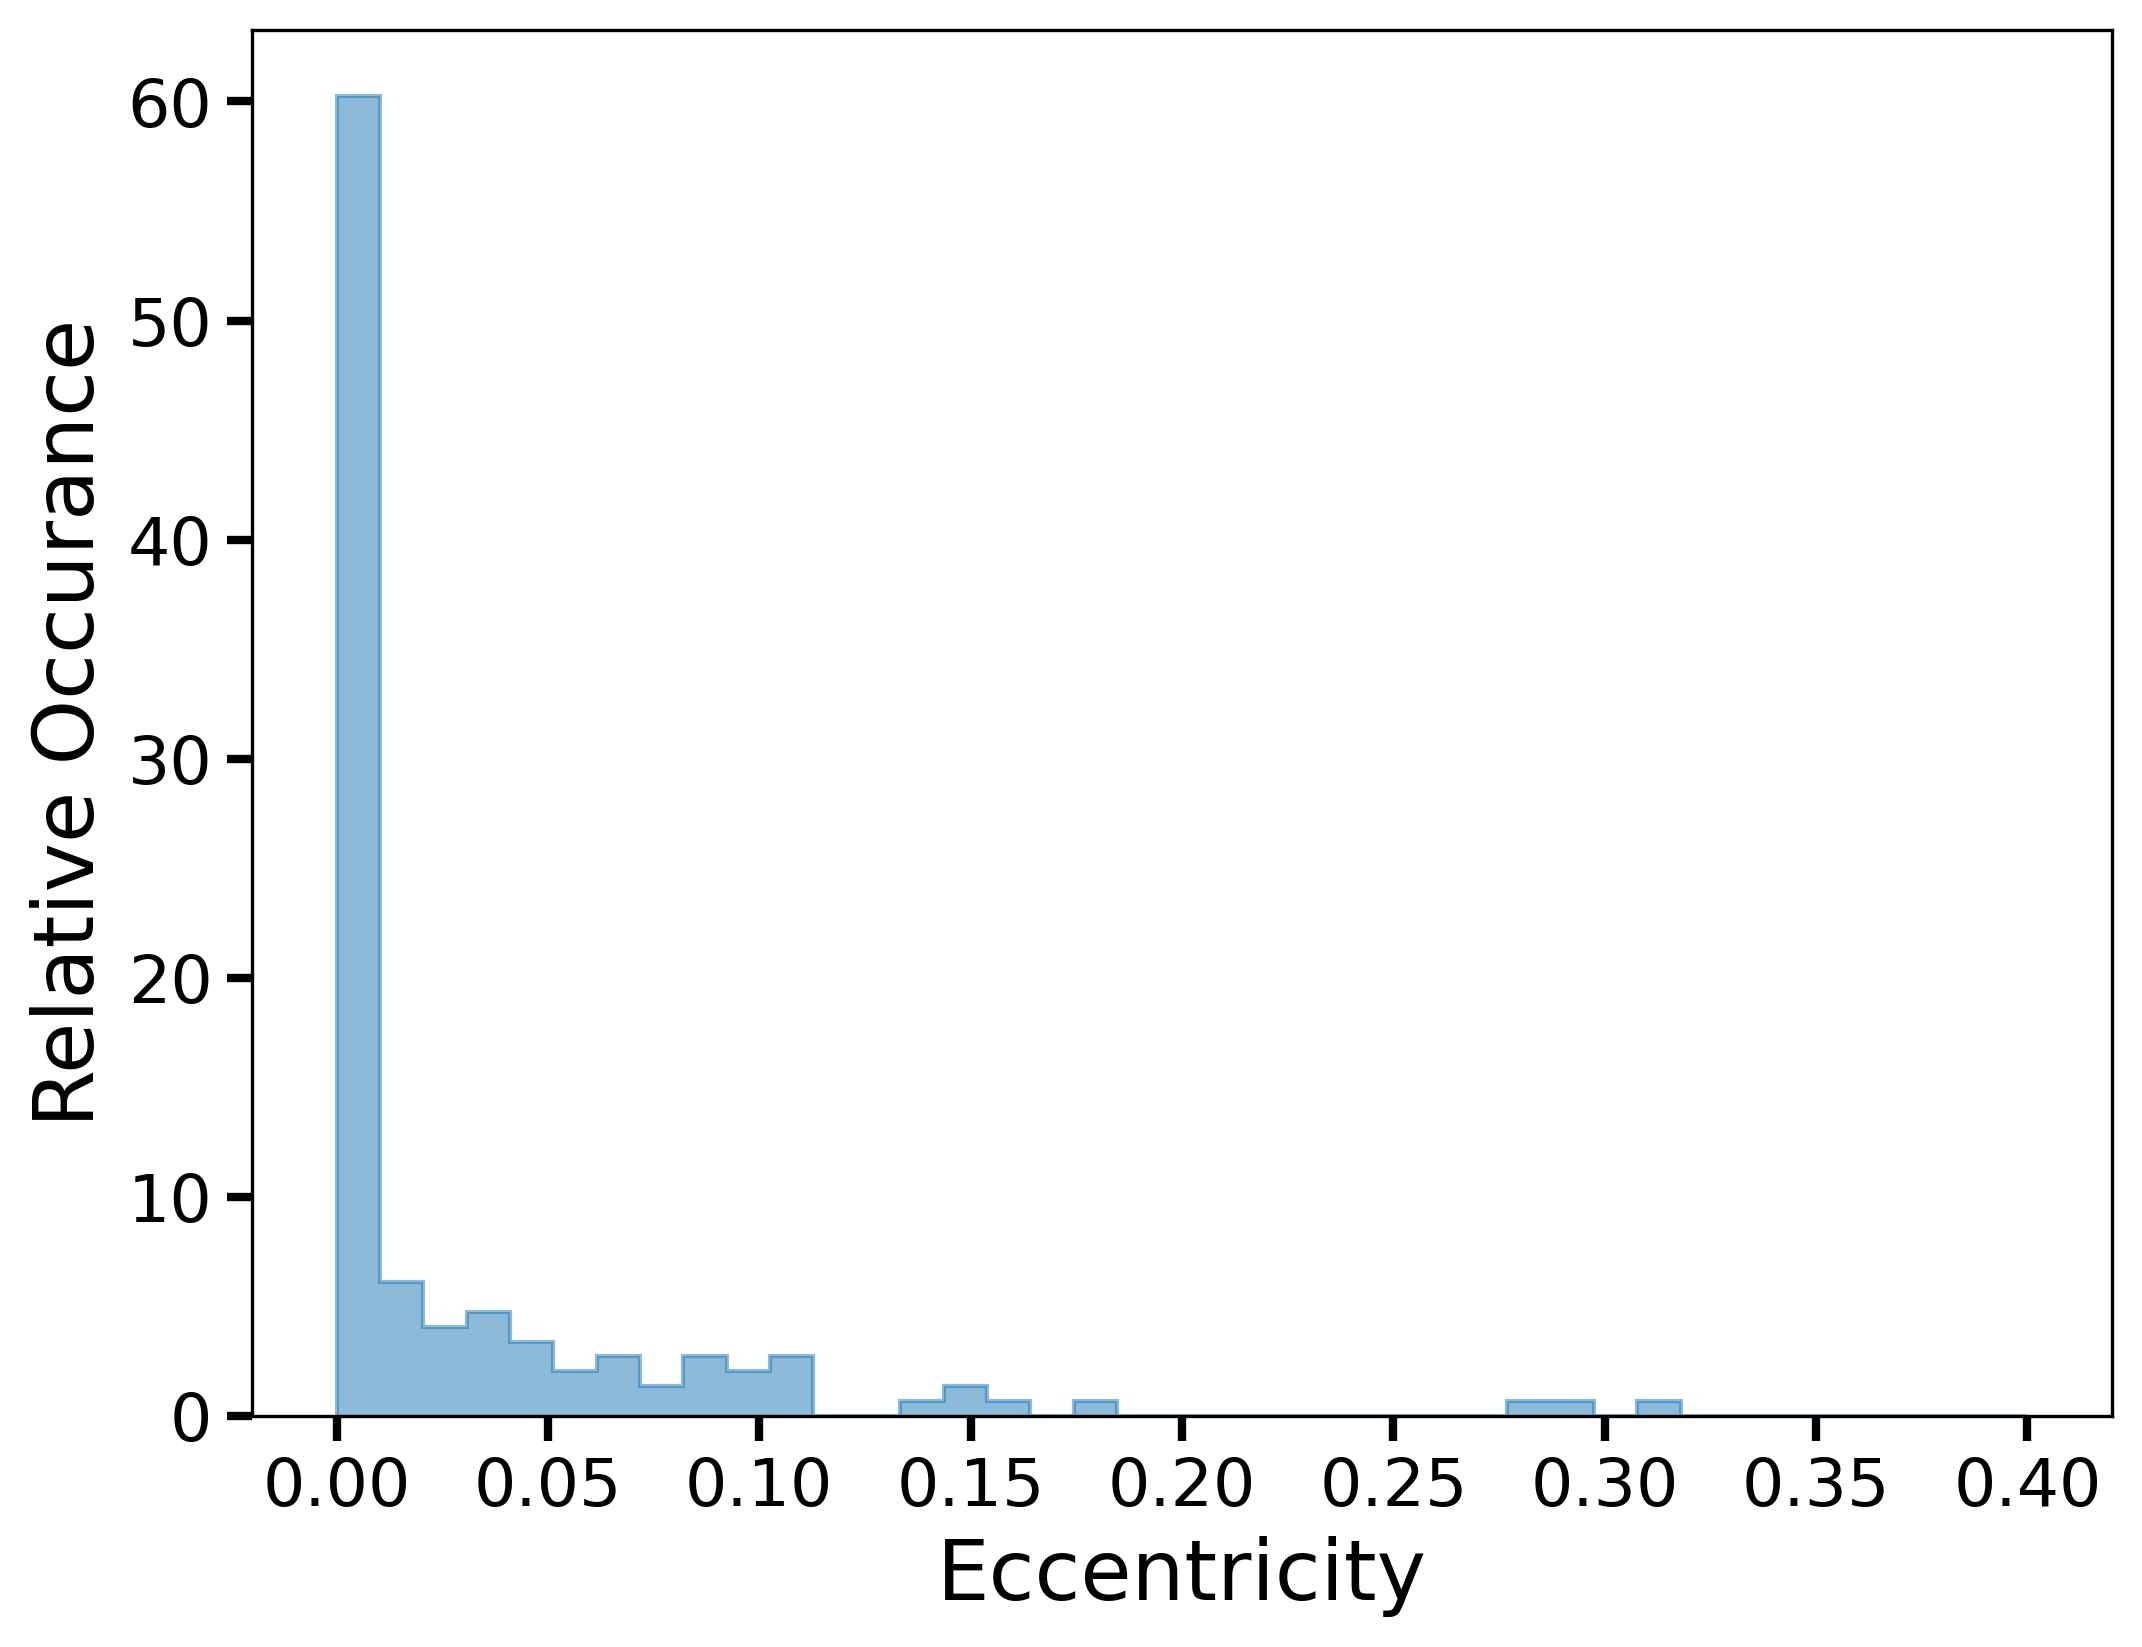

In [50]:
huh, ax = plt.subplots(figsize=(8,6), dpi=300)
# Load the data
plt.style.use('./paper.mplstyle')

eccentricity = df['Eccentricity'].to_numpy()

# Remove NaN and infinite values from the array
eccentricity = eccentricity[~np.isnan(eccentricity)]
#eccentricity = eccentricity[eccentricity != 0]
eccentricity = eccentricity[np.isfinite(eccentricity)]

# Fit a KDE to the data
kde_e = gaussian_kde(eccentricity)

# Generate 10000 samples from the KDE
e_list = kde_e.resample(size=150000)[0] #change eccentricity to be half of kde see how much change
e_list = np.array([choice(eccentricity) for n in range(0,150000)])
n, bins_e, patches = plt.hist(eccentricity, bins=np.linspace(0, 0.4, 40), histtype='step',fill=True, alpha=0.5, density=True, label = 'Observed')
# Plot the kernel density curve of the original data
#Create a histogram of the new samples
#n_new, bins_new, patches_new = plt.hist(e_list, bins=bins_e, histtype='step', fill=True, density=True, alpha=0.5,label = 'Synthetic')
#n2, bins_e2, patches2 = plt.hist(e_list_orig, bins=bins_e, histtype='step', density=True, fill=True,alpha=0.5, label = 'resampled')

# Plot the kernel density curve of the new samples, e_list spock selected from
kde_new_e = gaussian_kde(e_list)
#plot the actual eccentricities spock took
'''
n_s_new, bins_s_new, patches_s_new = plt.hist(spock_e_list, bins=bins_e, histtype='step', density=True, label = 'Spock Population')
kde_s_new = gaussian_kde(spock_e_list)
plt.plot(x_grid_e, kde_s_new(x_grid_e), label='Spock Population KDE')
'''

# Set plot title, labels, and legend
#plt.title("Observed Eccentricity Distribution")
plt.xlabel("Eccentricity")
plt.ylabel("Relative Occurance")
#plt.legend()

# Show the plot
huh.savefig('ObsEccen.pdf')
#plt.show()

# Dispersion for observed systems
D = 0.302449556680029

error = 0.0180067880312394 (SEM)

In [51]:
D = 0.302449556680029
D_error = 0.0180067880312394

In [52]:
# saving pvalues for each trial
trials_pvalue_mean = []
trials_pvalue_stdev = [] 
final_dispersion = []
eccentrios = []
masstrios = []
probabilitylist = []

In [53]:
from tqdm import tqdm 

# this saves lists of lists so we can save each from each ecc change
ecc_cumsum = []
ecc_final_pratios = [] 
ecc_pvalue = []
ecc_final_stability = []
ecc_final_simulations = []
ecc_final_all_pratios = []
ecc_final_bad_pratios = []
ecc_final_periods = []
ecc_inner_pratios = []
ecc_outer_pratios = []


counting_systems = 0

# multiple trials to take an average CHANGE
num_experiments = 100
# 1/2 expected is D
# stdev_changing = [6*D, 7*D, 8*D, 9*D]

stdev = D*3 # should have disp .3
#kde_changing = [0.5, 0.57434918, 0.65975396, 0.75785828, 0.87055056, 1.14869835, 1.31950791, 1.51571657, 1.74110113,2]
kde_changing = [1]
for a in range(len(kde_changing)):
    print('MASS FACTOR:' + str(kde_changing[a]))
    
    #This initializes the lists that populations can be added into
    trials_cumsum = []
    trials_final_pratios = [] 
    trials_pvalue = []
    trials_final_stability = []
    trials_final_simulations = []
    trials_final_bad_pratios = []
    trials_final_all_pratios = []
    trials_final_periods = []
    trials_inner_pratios = []
    trials_outer_pratios = []
    #dispersion_list = []
    final_periods = []
#     stdev = stdev_changing[a]
    for q in tqdm(range(num_experiments)):
#         if q % 20 == 0:
#             print(str(q+1)+'/'+str(num_experiments)) # print how many exp run every 20 exp
        spock_e_list = [] # final eccentricities of planets
        spock_p_list = [] # final period ratios of planets
        all_pratios = []
        bad_p_list = []
        spock_m_list = [] # final masses of planets
        final_stability = [] # final probabilities of each simulated system being stable
        final_simulations = [] # final simulations used
        inner_pratios = []
        outer_pratios = []
        
        #CHANGE
        while len(spock_p_list) < 73: # run until we get to 71 "simulated observations" 1.1-1.5
            #Get eccentricity and mass randomly
            #We're are testing a single system of 3 planets
            i = int(np.random.uniform(0,10000))
            j = int(np.random.uniform(0,len(ratlist)/3))
            sun_mass = 1
            temp_e1 = e_list[3*i] # choose random eccentricity, is there a reason why this is how it's randomly chosen
            temp_e2 = e_list[3*i+1]
            temp_e3 = e_list[3*i+2]
            temp_m1ratio = ratlist[3*j]*kde_changing[a]
            temp_m2ratio = ratlist[3*j+1]*kde_changing[a]
            temp_m3ratio = ratlist[3*j+2]*kde_changing[a]
            # Get periods based on pearson r requirement and period distribution. 
            #Initialize to base values
            base_period = 1  #PLay with this value based on observed periods, but might not matter
            #.44 pearson r?
           # dispersion #0.1161#0.1161 #This standard deviation sets the pearson r change by 50%
#             d_error = dispersion(trios=get_trios(Plist = plist))[1] # dispersion error
#             pratio1 = p_list[int(np.random.uniform(0,num_iter))] # choose a ratio between planet, choose from array of random period ratios between 1.1-1.5
#             pratio2_log = np.random.normal(pratio1,stdev*pratio1) #Use random.normal to imitate pearson r - tune stdev to desired pearson r
#             pratio2 = 10**pratio2_log
            period_1 = 1
            period_2 = np.random.uniform(1.1, 1.5)
            pratio1 = period_2/period_1
            s12 = np.log10(pratio1)
            period_3 = 0
            
            while period_3 < period_2:
                s23 = np.random.normal(loc=s12, scale=stdev*s12)
                period_3 = period_2 * 10 ** s23
                
            pratio2 = period_3/period_2
            #Set the periods based on period ratios and base period
    
    
#             period_1, period_2, period_3 = simulate_trios(d, d_error)
#             pratio1 = period_2/period_1
#             pratio2 = period_3/period_2
#             period_1 = base_period


#             period_2 = period_1 * pratio1
#             period_3 = period_2 * pratio2

            # Making the 3planet temporary simulation
            temp_sim = rebound.Simulation()
            temp_sim.add(m=sun_mass) #Can possibly change mass of star, but might not matter
            temp_sim.add(m=temp_m1ratio*sun_mass, P = period_1, e = temp_e1, pomega = "uniform")
            temp_sim.add(m=temp_m2ratio*sun_mass, P = period_2, e = temp_e2, pomega = "uniform")
            temp_sim.add(m=temp_m3ratio*sun_mass, P = period_3, e = temp_e3, pomega = "uniform")



            # Test stability of the temporary simulation
            temp_stability = fmodel.predict_stable(temp_sim)# get its spock probability for both groups of planets inner/outer

            # sets simulation stability to 0 if orbits cross
            if disp.check_crossing(temp_sim):
                temp_stability = 0

            r = np.random.random() # this generates a random number from 0-1
            if r < temp_stability: # condition will trigger temp_stability% of the time
                #print(temp_stability)
                final_simulations.append(temp_sim) # append simulation to our list of "simulated observations" that survived
                spock_p_list.append(pratio1)
                if (pratio2 > 1.1 and pratio2 < 1.5): #between constraints for small p ratio
                    spock_p_list.append(pratio2)
                else:
                    bad_p_list.append(pratio2)
                inner_pratios.append(pratio1)
                outer_pratios.append(pratio2)
                all_pratios.append(pratio1)
                all_pratios.append(pratio2)
                #NEED TO FIGURE OUT
                spock_e_list.append(temp_e1)
                spock_e_list.append(temp_e2)
                spock_e_list.append(temp_e3)
                spock_m_list.append(temp_m1ratio)
                spock_m_list.append(temp_m2ratio)
                spock_m_list.append(temp_m3ratio)
                probabilitylist.append(temp_stability)
                final_stability.append(temp_stability) # append stability probability to list of stabilities that survived
                final_periods.append([period_1,period_2,period_3]) #trios!
                counting_systems +=1

            else:
                counting_systems +=1
                pass # simulated observation was unsuccessful. Continue to making a new system and repeat

        # make cdf in spock_p_cumsum
        print(counting_systems)
        
        spock_p_values, spock_p_base = np.histogram(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number))
        spock_p_cumsum = np.cumsum(spock_p_values)/max(np.cumsum(spock_p_values)) #cdf!!!
        #print(spock_p_cusum)
        # ks test
        ksprob = scipy.stats.kstest(np.array(spock_p_list), np.array(pratios_observed), args=(), alternative='two-sided', method='exact')       
        pvalue = ksprob[1]
        
        # dispersion
#         dispersion_list.append(dispersion(trios=final_periods)[0])
        
        # SAVE DATA FROM AFTER WHILE LOOP, from all 71 runs
        # pvalue is 1 element for the 71 pratios created. this should be a list of length of num_experiments
        trials_pvalue.append(pvalue)

        trials_final_stability.append(final_stability) # list of stability arrays for each trial
        trials_final_pratios.append(spock_p_list) # list of period ratios for each trial
        trials_final_all_pratios.append(all_pratios)
        trials_final_bad_pratios.append(bad_p_list)
        trials_inner_pratios.append(inner_pratios)
        trials_outer_pratios.append(outer_pratios)
        trials_cumsum.append(spock_p_cumsum) # list of all cdfs corresponding to the period ratios 
        trials_final_simulations.append(final_simulations)
        trials_final_periods.append(final_periods)
    
    
    # list of list, from each change in eccentricity value
    final_dispersion.append(disp.dispersion(trios=final_periods))#statistics.mean(dispersion_list))
    
    # WHAT WE CARE ABOUT FOR SENSITIVITY TEST
    # ecc_pvalue is a LOL of ALL pvalues for each kde_changing
    # list is len(kde_changing) of list is len(num_experiments)
    ecc_pvalue.append(trials_pvalue) 
    ecc_cumsum.append(trials_cumsum) 
    

    #if str(kde_changing[a]) == "1":
        #np.save('RatPomMass'+str(kde_changing[a]), spock_m_list)
        #np.save('RatPomEccen'+str(kde_changing[a]), spock_e_list)
    ecc_final_stability.append(trials_final_stability) # list of stability arrays for each trial
    ecc_final_pratios.append(trials_final_pratios) # list of period ratios for each trial 
    ecc_final_all_pratios.append(trials_final_all_pratios)
    ecc_final_bad_pratios.append(trials_final_bad_pratios)
    ecc_cumsum.append(trials_cumsum) # list of all cdfs corresponding to the period ratios 
    ecc_final_simulations.append(trials_final_simulations)
    ecc_final_periods.append(trials_final_periods)
    ecc_inner_pratios.append(trials_inner_pratios)
    ecc_outer_pratios.append(trials_outer_pratios) 
    
    # easy access to mean and stdev, list 1 x len(kde_changing)
    trials_pvalue_mean.append(np.asarray(trials_pvalue).mean())
    trials_pvalue_stdev.append(statistics.stdev(trials_pvalue))
np.save('NormCS', ecc_cumsum)
np.save('NormPV', ecc_pvalue)
np.save("NormECCEN", spock_e_list)
#np.save("OldSPOCKstable",ecc_final_stability)

#np.save('OldSPOCKMASS', spock_m_list)
#np.save('OldSPOCKECCEN', spock_e_list)

MASS FACTOR:1


  0%|                                                                                           | 0/100 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(len(ecc_cumsum[1]))
print(ecc_pvalue)
print(len(ecc_pvalue[0]))